In [1]:
# self-define function
from data_cleaning import cleaning_text_QA, sentence_df
from participant_function import participants_list, clean_participants_list
# from stock_price_info import stock_price_change\
# read and saving path
path = "./meeting_transcript"
text_save_path = "./output_QA"

In [2]:
# other packages
import pdftotext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import string

In [3]:
import nltk 
nltk.download('twitter_samples')
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords          # module for stop words that come with NLTK
nltk.download('stopwords')
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import spacy 
nlp = spacy.load("en_core_web_lg")

In [5]:
from tqdm import tqdm

In [6]:
# tp_modelling packages
from collections import Counter, OrderedDict
from gensim.models import Phrases
import tomotopy as tp

# Reading the folders and files

In [7]:
# all files path
company_paths = []
sectors = os.listdir(path) 
if '.DS_Store' in sectors:
    sectors.remove('.DS_Store')

for sector in sectors:
    # path to each sector files
    sector_path = path+"/"+sector
    
    # path to each company files
    companies = os.listdir(sector_path)
    if '.DS_Store' in companies:
        companies.remove('.DS_Store')
    
    for company in companies:
        tmp = sector_path+"/"+company
        company_paths.append(tmp)

Concat the text to one dataframe

In [19]:
# ################################## checking with DF (not necessary) ###################################
# company_paticipants_df = pd.DataFrame()
# other_paticipants_df = pd.DataFrame()
# ########################################################################################################

df_clean_na = pd.DataFrame(np.zeros((2500,1)), columns=['index']) # create a dataframe with 2500 rows 
company_paticipants_list = [] 
other_paticipants_list = []

for single_path in company_paths:
    files = os.listdir(single_path)
    for file in files:
        # print(file)
        if file.endswith(".pdf"):
            # print(file)
            # Load PDF
            with open(single_path+"/"+file, "rb") as f:
                pdf = pdftotext.PDF(f)
            # Save all text to a txt file.
            with open(text_save_path+"/"+file.replace(".pdf", ".txt"), "w") as f:
                f.write("\n\n".join(pdf))
            # open the text file
            with open(text_save_path+"/"+file.replace(".pdf", ".txt")) as f:
                content_list = f.readlines()
                # remove the '"' inside the text
                content_list = [re.sub(r'[\n]', '', x) for x in content_list]
                content_list = [re.sub(r'["]', '', x) for x in content_list]
                content_list = [re.sub(r'[\x0c]', '', x) for x in content_list]

                # make each row as a sentence
                contents = pd.DataFrame(content_list)
                # use astype to convert to string
                contents = contents.astype(str)
                contents[0] = contents[0].str.replace('"','')

                df_clean = cleaning_text_QA(contents)  ##### ------> here we use the function from data_cleaning.py
                
                # extract the participants
                tmp_df_text,tmp_company_paticipants,tmp_other_paticipants = participants_list(df_clean) ##### ------> here we use the function from participant_function.py
                company_paticipants_list.append(tmp_company_paticipants)
                other_paticipants_list.append(tmp_other_paticipants)                   

                index_presentation = tmp_df_text[tmp_df_text[0] == 'Presentation'].index
                if len(index_presentation) == 2:
                    tmp_df_text.loc[index_presentation[0], 0] = 'heading' # replace the first index_presentation in df_clean with "head" ##### ------> interacting with the participant_function.py

                # get only the QA part
                QA_index = tmp_df_text.index[tmp_df_text.iloc[:,0] == 'Questions And Answers'].tolist()
                # get the index of the last row of tmp_df_text
                end_index = [len(tmp_df_text)]
                if QA_index == []:
                    QA_index = tmp_df_text.index[tmp_df_text.iloc[:,0] == 'Q&A'].tolist()
                    end_index = [len(tmp_df_text)]
                    # if QA_index == []:
                    #     QA_index = tmp_df_text.index[tmp_df_text.iloc[:,0] == '(Questions And Answers)'].tolist()
                    #     end_index = [len(tmp_df_text)]
                    #     if QA_index == []:
                    #         QA_index = tmp_df_text.index[tmp_df_text.iloc[:,0] == '(Q&A)'].tolist()
                    #         end_index = [len(tmp_df_text)]
                    if QA_index == []:
                        end_index = []
                    
                if QA_index != []:
                    tmp_df_text_QA = tmp_df_text.iloc[QA_index[0]+1:end_index[0]]
                # replace to "" if the row is "(Question And Answer)"
                tmp_df_text_QA[0] = tmp_df_text_QA[0].str.replace('(Question And Answer)',' ')
                tmp_df_text_QA[0] = tmp_df_text_QA[0].str.replace('(Questions And Answers)',' ')
                tmp_df_text_QA[0] = tmp_df_text_QA[0].str.replace('(Q&A)','')
                tmp_df_text_QA[0] = tmp_df_text_QA[0].str.replace('(Operator Instructions)',' ')
                tmp_df_text_QA[0] = tmp_df_text_QA[0].str.replace('(inaudible)',' ')
                tmp_df_text_QA[0] = tmp_df_text_QA[0].str.replace('(',' ')
                tmp_df_text_QA[0] = tmp_df_text_QA[0].str.replace(')',' ')
                tmp_df_text_QA = tmp_df_text_QA.reset_index(drop=True)
                

                # ################################## checking with DF (not necessary) ###################################
                # company_paticipants = pd.DataFrame(company_paticipants)
                # if company_paticipants.empty:
                #     company_paticipants = pd.DataFrame(np.zeros((1,1)), columns=['index'])
                # company_paticipants_df[f"{files[files.index(file)]}"] = company_paticipants
                # other_paticipants = pd.DataFrame(other_paticipants)
                # if other_paticipants.empty:
                #     other_paticipants = pd.DataFrame(np.zeros((1,1)), columns=['index'])
                # other_paticipants_df[f"{files[files.index(file)]}"] = other_paticipants
                # ########################################################################################################
                
                df = pd.DataFrame()
                df[f"{files[files.index(file)]}"] = tmp_df_text_QA
                # remove the row using re, if the row ends with Presentation  Investor Day	
                df_clean_na[f"{files[files.index(file)]}"] = df[f"{files[files.index(file)]}"].dropna(inplace=False).reset_index(drop=True)

# drop the first column of the df
df_clean_na = df_clean_na.iloc[:,1:]
df_clean_na.head(5)

/Users/timliu/Documents/GitHub/BoE_ARP/data_cleaning.py:212: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[0] = df[0].str.replace('*','')
/Users/timliu/Documents/GitHub/BoE_ARP/data_cleaning.py:213: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[0] = df[0].str.replace('[','')
/Users/timliu/Documents/GitHub/BoE_ARP/data_cleaning.py:214: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[0] = df[0].str.replace(']','')
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_61802/3421763784.py:66: FutureWarning: The d

,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_RT000000002903022737.pdf,20210811_Quilter_PLC-_Earnings_Call_2021-8-11_RT000000002962310912.pdf,20200311_Quilter_PLC-_Earnings_Call_2020-3-11_DN000000002822346246.pdf,20200811_Quilter_PLC-_Earnings_Call_2020-8-11_DN000000002883967732.pdf,20190805_Quilter_PLC-_Earnings_Call_2019-8-5_RT000000002897819838.pdf,20180808_Quilter_PLC-_Earnings_Call_2018-8-8_FS000000002459369907.pdf,20210401_Quilter_PLC-_M-A_Call_2021-4-1_RT000000002954187686.pdf,20171219_Quilter_PLC-_M-A_Call_2017-12-19_SD000000002919419964.pdf,20210310_Quilter_PLC-_Earnings_Call_2021-3-10_RT000000002952420637.pdf,20140904_Sanlam_Ltd-_Earnings_Call_2014-9-4_DN000000002170588806.pdf,...,20140424_Everest_Re_Group_Ltd-_Earnings_Call_2014-4-24_SD000000002701577115.pdf,20211028_Everest_Re_Group_Ltd-_Earnings_Call_2021-10-28_DN000000002966766153.pdf,20170207_Everest_Re_Group_Ltd-_Earnings_Call_2017-2-7_FS000000002327179820.pdf,20160204_Everest_Re_Group_Ltd-_Earnings_Call_2016-2-4_FS000000002251252548.pdf,20140724_Everest_Re_Group_Ltd-_Earnings_Call_2014-7-24_FS000000002439093631.pdf,20171031_Everest_Re_Group_Ltd-_Earnings_Call_2017-10-31_DN000000002379633496.pdf,20150428_Everest_Re_Group_Ltd-_Earnings_Call_2015-4-28_FS000000002207058997.pdf,20120726_Everest_Re_Group_Ltd-_Earnings_Call_2012-7-26_SD000000002701554249.pdf,20121025_Everest_Re_Group_Ltd-_Earnings_Call_2012-10-25_SD000000002719409327.pdf,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2013-7-24_SD000000002719418375.pdf
0,Paul Feeney,Operator,Andrew Sinclair,Operator,Operator,Andrew Sinclair,Operator,Operator,Operator,Unidentified Participant,...,Operator,Operator,Operator,Operator,Operator,Operator,Operator,Operator,Operator,Operator
1,,,Thanks. It's Andy Sinclair from Bank of Americ...,Our first question comes from the line of Andr...,,Thanks. It's Andy Sinclair from BoFA Merrill L...,,And our first question comes from Andy Sin...,,.,...,Thank you. The question and answer session wil...,And your first question is from Elyse Gree...,Certainly. And we will go first to Elyse Green...,Thank you. Thank you. Our first question comes...,Thank you. And we'll go first to Amit Kumar wi...,. And we will go first to Elyse Greenspan w...,We'll take our first question from Kai Pan wit...,,,"Amit Kumar, Macquarie Capital."
2,Andrew Sinclair,Thank you. Our first question comes from t...,"please. Firstly, really good to see the platfo...",ahead.,Andrew Sinclair,number of Restricted Financial Planners. That'...,Thank you. Our first question comes from t...,America Merrill Lynch.,Thank you. Let's go with our first questio...,Johan van Zyl,...,Instructions Our first question will come from...,Elyse Greenspan,Elyse B. Greenspan,your line is open.,Amit Kumar,Elyse Greenspan,Kai Pan,"Amit Kumar, Macquarie.",Gregory Locraft with Morgan Stanley.,Amit Kumar
3,Thanks. It's Andrew Sinclair from BofA Merrill...,Sinclair of Bank of America. Please go ahead. ...,"on a bit of bizarre market, but I just wondere...",Andrew Sinclair,Thanks. This is Andrew Sinclair Bank of the Me...,wondering if you can give us thoughts on H2 gr...,from Bank of America. Please go ahead.,Andrew Sinclair,of America. Your line is now open. Please go a...,"Well, of course, we have to talk about the ...",...,Jay Gelb,Hi. Thanks. Good morning. My first question is...,"Hi. Good morning. First off, if you could just...",Vinay Misquith,Thanks and good morning. Just two quick questi...,"Hi, good morning. My first question, just on g...",Good morning. Thank you. And first question is...,Amit Kumar,Gregory Locraf t,Thanks and good morning. I guess two or three ...
4,"So firstly, just on adviser recruitment. Just ...",Andrew Sinclair,flows are differring for advisers who have mig...,"Thanks, and good morning, everyone. Three from...","okay. Firstly on Lighthouse, Inaudible not s...",strong recruitment.,Andrew Sinclair,"I have 3 questions, if I may. Firstly, I just ...",Andrew Sinclair,"behavior like, for instance, if people don't c.

Clean the participants list and get all, company, and other participants list

In [20]:
# generating all the participants
company_paticipants_list = clean_participants_list(company_paticipants_list)
other_paticipants_list = clean_participants_list(other_paticipants_list)
all_participants_list_tmp = []
all_participants_list_tmp = company_paticipants_list + other_paticipants_list

# drop the duplicates
all_participants_list = []
for x in all_participants_list_tmp:
    if x not in all_participants_list:
        all_participants_list.append(x)


Add two columns which include participants and the index of the participant (to be used for merging as paragraph)

In [21]:
concat_df = pd.DataFrame()
participants_index =pd.DataFrame(np.zeros((2500,1)), columns=['index'])
for column in df_clean_na.columns:
    # identify all the rows in df with all_participants_list in it
    both_participants_row_index = df_clean_na[df_clean_na[column].isin(all_participants_list)].index.tolist()
    # apply the both_participants_row_index to the df_clean_na['participants']
    concat_df[column] = df_clean_na[column]
    ppt_list = df_clean_na[column].apply(lambda x: x if x in all_participants_list else 0)
    idx_list = [int(idx) if ppt_list[idx] != 0 else np.nan for idx in range(len(ppt_list)) ]
    # adding paricipants name
    concat_df[f"participants_{column}"] = [name if name != 0 else np.nan for name in ppt_list]
    # adding index columns
    concat_df[f"idx_{column}"] = idx_list
    # fill the NaN with the value of the previous row
    concat_df[f"participants_{column}"] = concat_df[f"participants_{column}"].fillna(method='ffill')
    concat_df[f"idx_{column}"] = concat_df[f"idx_{column}"].fillna(method='ffill')

concat_df

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_61802/3263364826.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_df[f"participants_{column}"] = [name if name != 0 else np.nan for name in ppt_list]
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_61802/3263364826.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_df[f"idx_{column}"] = idx_list
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_61802/3263364826.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is us

,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_RT000000002903022737.pdf,participants_20190312_Quilter_PLC-_Earnings_Call_2019-3-12_RT000000002903022737.pdf,idx_20190312_Quilter_PLC-_Earnings_Call_2019-3-12_RT000000002903022737.pdf,20210811_Quilter_PLC-_Earnings_Call_2021-8-11_RT000000002962310912.pdf,participants_20210811_Quilter_PLC-_Earnings_Call_2021-8-11_RT000000002962310912.pdf,idx_20210811_Quilter_PLC-_Earnings_Call_2021-8-11_RT000000002962310912.pdf,20200311_Quilter_PLC-_Earnings_Call_2020-3-11_DN000000002822346246.pdf,participants_20200311_Quilter_PLC-_Earnings_Call_2020-3-11_DN000000002822346246.pdf,idx_20200311_Quilter_PLC-_Earnings_Call_2020-3-11_DN000000002822346246.pdf,20200811_Quilter_PLC-_Earnings_Call_2020-8-11_DN000000002883967732.pdf,...,idx_20150428_Everest_Re_Group_Ltd-_Earnings_Call_2015-4-28_FS000000002207058997.pdf,20120726_Everest_Re_Group_Ltd-_Earnings_Call_2012-7-26_SD000000002701554249.pdf,participants_20120726_Everest_Re_Group_Ltd-_Earnings_Call_2012-7-26_SD000000002701554249.pdf,idx_20120726_Everest_Re_Group_Ltd-_Earnings_Call_2012-7-26_SD000000002701554249.pdf,20121025_Everest_Re_Group_Ltd-_Earnings_Call_2012-10-25_SD000000002719409327.pdf,participants_20121025_Everest_Re_Group_Ltd-_Earnings_Call_2012-10-25_SD000000002719409327.pdf,idx_20121025_Everest_Re_Group_Ltd-_Earnings_Call_2012-10-25_SD000000002719409327.pdf,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2013-7-24_SD000000002719418375.pdf,participants_20130724_Everest_Re_Group_Ltd-_Earnings_Call_2013-7-24_SD000000002719418375.pdf,idx_20130724_Everest_Re_Group_Ltd-_Earnings_Call_2013-7-24_SD000000002719418375.pdf
0,Paul Feeney,Paul Feeney,0.0,Operator,Operator,0.0,Andrew Sinclair,Andrew Sinclair,0.0,Operator,...,0.0,Operator,Operator,0.0,Operator,Operator,0.0,Operator,Operator,0.0
1,,Paul Feeney,0.0,,Operator,0.0,Thanks. It's Andy Sinclair from Bank of Americ...,Andrew Sinclair,0.0,Our first question comes from the line of Andr...,...,0.0,,Operator,0.0,,Operator,0.0,"Amit Kumar, Macquarie Capital.",Operator,0.0
2,Andrew Sinclair,Andrew Sinclair,2.0,Thank you. Our first question comes from t...,Operator,0.0,"please. Firstly, really good to see the platfo...",Andrew Sinclair,0.0,ahead.,...,2.0,"Amit Kumar, Macquarie.",Operator,0.0,Gregory Locraft with Morgan Stanley.,Operator,0.0,Amit Kumar,Amit Kumar,2.0
3,Thanks. It's Andrew Sinclair from BofA Merrill...,Andrew Sinclair,2.0,Sinclair of Bank of America. Please go ahead. ...,Operator,0.0,"on a bit of bizarre market, but I just wondere...",Andrew Sinclair,0.0,Andrew Sinclair,...,2.0,Amit Kumar,Amit Kumar,3.0,Gregory Locraf t,Operator,0.0,Thanks and good morning. I guess two or three ...,Amit Kumar,2.0
4,"So firstly, just on adviser recruitment. Just ...",Andrew Sinclair,2.0,Andrew Sinclair,Andrew Sinclair,4.0,flows are differring for advisers who have mig...,Andrew Sinclair,0.0,"Thanks, and good morning, everyone. Three from...",...,2.0,"Thanks, and congrats on a very strong quarter....",Amit Kumar,3.0,"Thanks. Good morning, and congrats on another ...",Operator,0.0,back on the discussion on the business mix -- ...,Amit Kumar,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,NaN,Paul Feeney,159.0,NaN,Paul Feeney,416.0,NaN,Paul Feeney,202.0,NaN,...,468.0,NaN,Operator,341.0,NaN,Operator,422.0,NaN,Operator,352.0
2496,NaN,Paul Feeney,159.0,NaN,Paul Feeney,416.0,NaN,Paul Feeney,202.0,NaN,...,468.0,NaN,Operator,341.0,NaN,Operator,422.0,NaN,Operator,352.0
2497,NaN,Paul Feeney,159.0,NaN,Paul Feeney,416.0,NaN,Paul Feeney,202.0,NaN,...,468.0,NaN,Operator,341.0,NaN,Operator,422.0,NaN,Operator,352.0
2498,NaN,Paul Feeney,159.0,NaN,Paul Feeney,416.0,NaN,Paul Feeney,202.0,NaN,...,468.0,NaN,Operator,341.0,NaN,Operator,422.0,NaN,Operator,352.0


make the dataframe as horizontal instead of vertical, and get the company_paticipants_yes and other_paticipants_yes

In [22]:
model_df = pd.DataFrame()
for i in range(int(len(concat_df.columns.to_list())/3)):
    #print(i)
    tmp_df = pd.DataFrame()
    tmp_df = concat_df.iloc[:,(i*3):(i*3)+3].copy()
    # extract the index as column from the text
    tmp_df['file_name'] = tmp_df.columns.to_list()[0]
    # extract the date from the index column
    tmp_df['date'] = tmp_df['file_name'].apply(lambda x: x.split('_')[0])
    # change the date column to datetime
    tmp_df['date'] = pd.to_datetime(tmp_df['date'])
    # rename to be consistent with the column name
    tmp_df.columns = ["line", "participants",  "idx", "file_name","date"]
    # if the 'participants' column's value equals to any of the company_paticipants_list, other_paticipants_list, then set the value to 0
    tmp_df['company_paticipants_yes'] = tmp_df['participants'].apply(lambda x: 1 if x in company_paticipants_list else 0)
    tmp_df['other_paticipants_yes'] = tmp_df['participants'].apply(lambda x: 1 if x in other_paticipants_list else 0)
    # drop the row if the column "line" is NaN
    tmp_df = tmp_df.dropna(subset=['line'], how='all')
    tmp_df['company_name1']  = tmp_df['file_name'].apply(lambda x: x.split('_')[1])
    tmp_df['company_name2']  = tmp_df['file_name'].apply(lambda x: x.split('_')[2])
    tmp_df['company_name'] = tmp_df["company_name1"] + " " + tmp_df["company_name2"]
    # drop the 'company_name1' and 'company_name2' column
    tmp_df = tmp_df.drop(columns=['company_name1', 'company_name2']).reset_index(drop=True)
    # drop line contains only participants name
    id_rows = tmp_df[tmp_df['line']==tmp_df['participants']].index
    tmp_df = tmp_df.drop(id_rows)
    # append into dataframe
    model_df = model_df.append(tmp_df)

# drop the Nan rows (no participants and idx, which are not what we want)
model_df = model_df.dropna(subset=['participants','idx'], how='all')
model_df

,line,participants,idx,file_name,date,company_paticipants_yes,other_paticipants_yes,company_name
1,,Paul Feeney,0.0,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_...,2019-03-12,1,0,Quilter PLC-
3,Thanks. It's Andrew Sinclair from BofA Merrill...,Andrew Sinclair,2.0,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_...,2019-03-12,0,1,Quilter PLC-
4,"So firstly, just on adviser recruitment. Just ...",Andrew Sinclair,2.0,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_...,2019-03-12,0,1,Quilter PLC-
5,on the pipeline after the Charles Darby acquis...,Andrew Sinclair,2.0,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_...,2019-03-12,0,1,Quilter PLC-
6,"2019? And secondly, on the operating margin ta...",Andrew Sinclair,2.0,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_...,2019-03-12,0,1,Quilter PLC-
...,...,...,...,...,...,...,...,...
346,"Great, thank you.",Brian Meredith,345.0,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2...,2013-07-24,1,1,Everest Re
348,This does conclude today's question-and-answer...,Operator,347.0,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2...,2013-07-24,1,1,Everest Re
349,back over to management for any closing or add...,Operator,347.0,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2...,2013-07-24,1,1,Everest Re
351,I would just like to thank everybody for joini...,Beth Farrell,350.0,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2...,2013-07-24,1,0,Everest Re


Use the idx to merge the participants and the text, the model_df will represent with paragraph and the other details

In [23]:
# model_df groupby 'participants','file_name','date','company_paticipants_yes','other_paticipants_yes','company_name' with ['sentence'] and .apply(' '.join)
model_df = model_df.groupby(['participants','file_name','date', 'idx', 'company_paticipants_yes','other_paticipants_yes','company_name'])['line'].apply(' '.join).reset_index()
# model_df rename the column 'sentence' to 'paraghrph'
model_df.columns = ['participants','file_name','date', 'idx', 'company_paticipants_yes','other_paticipants_yes','company_name','paraghrph']
model_df

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph
0,05HFRJ-E Denis Kessler,20190220_SCOR_SE-_Earnings_Call_2019-2-20_FS00...,2019-02-20,495.0,1,0,SCOR SE-,"Maybe before Ian takes the floor, we feel good..."
1,<Q >,20160722_Beazley_PLC-_Earnings_Call_2016-7-22_...,2016-07-22,330.0,1,0,Beazley PLC-,Just a follow-up. It is again on the capital s...
2,<Q – 05RN78-E Jay Gelb,20161219_FAIRFAX_FINL_HLD-_M-A_Call_2016-12-19...,2016-12-19,83.0,0,1,FAIRFAX FINL,> Thanks very much. Couple of questions. First...
3,<Q>,20140709_Aviva_PLC-_Shareholder_Mtg_Call_2014-...,2014-07-09,115.0,1,0,Aviva PLC-,"010039 , basically the cash flow, well, it re..."
4,Aaron Henry Meder,20180620_LEGAL_-_GEN_GRP-_Shareholder_Mtg_Call...,2018-06-20,214.0,1,0,LEGAL -,Yeah. It probably depends a little bit on kind...
...,...,...,...,...,...,...,...,...
145072,Yvonne van Rooij,20170601_NN_Group_NV-_Shareholder_Mtg_Call_201...,2017-06-01,1319.0,1,0,NN Group,"Yes, Mr. Chair. As the Supervisory Board, we a..."
145073,Yvonne van Rooij,20170601_NN_Group_NV-_Shareholder_Mtg_Call_201...,2017-06-01,1383.0,1,0,NN Group,"Ladies and gentlemen, based on the active fina..."
145074,Zack Perry,20160429_FAIRFAX_FINL_HLD-_Earnings_Call_2016-...,2016-04-29,194.0,0,1,FAIRFAX FINL,"Yeah, good morning. Thanks for taking the ques..."
145075,Zak Smerczak,20140507_LEGAL_-_GEN_GRP-_Sales_Results_Call_2...,2014-05-07,337.0,0,1,LEGAL -,My question's been answered. Thanks.


# Remove the participants and post_clean

In [24]:
def clean_tokens(text_series):
    # step 1: convert text_series df to list
    text_list = text_series.to_list()

    # # step 2: change the list to lower case
    # text_list = list(map(lambda x: x.lower(),text_list))

    # step 3: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    text_list=list(map(lambda x: remove_whitespace(x),text_list))

    # step 4: apply nlp pipeline remove stop words, numbers and lematize the words
    # expand the list of stopwords
    gist_file = open("./input/gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
        
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
        nlp.Defaults.stop_words.add(i)

    # create colloum for cleaned text_list
    tokens, tmp_tokens = [], [] 
    for text in tqdm(text_list): # or tqdm.tqdm
        tmp_tokens = [
            token.lemma_
            for token in nlp(text)
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]
        tokens.append(tmp_tokens)
        tmp_tokens=[]
    return tokens

Remove the name in the text

In [25]:
def participants_tokens(all_participants_list):
    # all_participants_list list to dataframe
    tmp_df = pd.DataFrame(all_participants_list)
    # test replace the dot with ""
    tmp_df[0] = tmp_df[0].str.replace('.','')
    # apply the clean_tokens function to the tmp_df dataframe
    tmp_participants_tokens = clean_tokens(tmp_df[0])
    # append all the tokens to list
    participants_tokens = []
    for i in tmp_participants_tokens:
        participants_tokens.extend(i)
    return participants_tokens

participants_tokens = participants_tokens(all_participants_list)
# participants_tokens remove the vlaue that the len is less than 3
participants_tokens = [i for i in participants_tokens if len(i)>2]
# participants_tokens

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_61802/3219497472.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tmp_df[0] = tmp_df[0].str.replace('.','')
100%|██████████| 2736/2736 [00:11<00:00, 248.58it/s]


In [26]:
# # lowercase the all_participants_list, for the purpose of removing in the model_df (which is not important for the model)
# all_participants_list_lc = [i.lower() for i in all_participants_list]

In [27]:
def post_process(df):
    # create a new column 'paraghrph_clean'
    df['paraghrph_clean'] = df['paraghrph']
    # remove the participants name from 'paraghrph' if exist in participants_tokens
    for i in participants_tokens:
        df['paraghrph_clean'] = df['paraghrph_clean'].str.replace(i,'')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace(',','')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('.','')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('(','')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace(')','')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('(through translator)','')

    return df

model_df = post_process(model_df)

pd.set_option('display.max_columns', None)
print(model_df['file_name'].nunique())
model_df

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_61802/4063045589.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('.','')
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_61802/4063045589.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('(','')
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_61802/4063045589.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['parag

1987


,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean
0,05HFRJ-E Denis Kessler,20190220_SCOR_SE-_Earnings_Call_2019-2-20_FS00...,2019-02-20,495.0,1,0,SCOR SE-,"Maybe before Ian takes the floor, we feel good...",Maybe before takes the floor we feel good and...
1,<Q >,20160722_Beazley_PLC-_Earnings_Call_2016-7-22_...,2016-07-22,330.0,1,0,Beazley PLC-,Just a follow-up. It is again on the capital s...,Just a follow-up It is again on the capital su...
2,<Q – 05RN78-E Jay Gelb,20161219_FAIRFAX_FINL_HLD-_M-A_Call_2016-12-19...,2016-12-19,83.0,0,1,FAIRFAX FINL,> Thanks very much. Couple of questions. First...,> Thanks very much Couple of questions First f...
3,<Q>,20140709_Aviva_PLC-_Shareholder_Mtg_Call_2014-...,2014-07-09,115.0,1,0,Aviva PLC-,"010039 , basically the cash flow, well, it re...",010039 basically the cash flow well it remai...
4,Aaron Henry Meder,20180620_LEGAL_-_GEN_GRP-_Shareholder_Mtg_Call...,2018-06-20,214.0,1,0,LEGAL -,Yeah. It probably depends a little bit on kind...,Yeah It probably depends a little bit on kind ...
...,...,...,...,...,...,...,...,...,...
145072,Yvonne van Rooij,20170601_NN_Group_NV-_Shareholder_Mtg_Call_201...,2017-06-01,1319.0,1,0,NN Group,"Yes, Mr. Chair. As the Supervisory Board, we a...",Yes Mr Chair As the Supervisory we aim for a ...
145073,Yvonne van Rooij,20170601_NN_Group_NV-_Shareholder_Mtg_Call_201...,2017-06-01,1383.0,1,0,NN Group,"Ladies and gentlemen, based on the active fina...",Ladies and gentlemen based on the active finan...
145074,Zack Perry,20160429_FAIRFAX_FINL_HLD-_Earnings_Call_2016-...,2016-04-29,194.0,0,1,FAIRFAX FINL,"Yeah, good morning. Thanks for taking the ques...",Yeah good morning Thanks for taking the questi...
145075,Zak Smerczak,20140507_LEGAL_-_GEN_GRP-_Sales_Results_Call_2...,2014-05-07,337.0,0,1,LEGAL -,My question's been answered. Thanks.,My question's been answered Thanks


Remove the numeric values

In [28]:
# remove the numeric values from the 'paraghrph_clean' column by str.replace('\d+', '')
model_df['paraghrph_clean'] = model_df['paraghrph_clean'].str.replace('\d+', '')
model_df['paraghrph_clean']= model_df['paraghrph_clean'].astype(str)

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_61802/2780780902.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  model_df['paraghrph_clean'] = model_df['paraghrph_clean'].str.replace('\d+', '')


In [29]:
nlp = spacy.load("en_core_web_lg", disable=["parser", "ner"])
# nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
def lemmatization(texts, allowed_postags=["NOUN"]):
    doc = nlp(texts)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    return (final) # 

# use apply the lemmatization function to the tmp_df dataframe
model_df['paraghrph_noun'] = model_df['paraghrph_clean'].apply(lemmatization)

# save the dataframe to csv file
model_df.to_csv('./main_df_output/topic_modelling_QA_df.csv', index=False) # careful the file is not saving tokenized data
model_df.head(3)

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun
0,05HFRJ-E Denis Kessler,20190220_SCOR_SE-_Earnings_Call_2019-2-20_FS00...,2019-02-20,495.0,1,0,SCOR SE-,"Maybe before Ian takes the floor, we feel good...",Maybe before takes the floor we feel good and...,floor advertising campaign company board yeste...
1,<Q >,20160722_Beazley_PLC-_Earnings_Call_2016-7-22_...,2016-07-22,330.0,1,0,Beazley PLC-,Just a follow-up. It is again on the capital s...,Just a follow-up It is again on the capital su...,up capital subject danger point term capital b...
2,<Q – 05RN78-E Jay Gelb,20161219_FAIRFAX_FINL_HLD-_M-A_Call_2016-12-19...,2016-12-19,83.0,0,1,FAIRFAX FINL,> Thanks very much. Couple of questions. First...,> Thanks very much Couple of questions First f...,thank couple question proxy insight term proce...


Load the df so the above we don't have to rerun anagin

In [68]:
# call out the model_df CSV
model_df = pd.read_csv('./main_df_output/topic_modelling_QA_df.csv')
# model_df sort by date
model_df = model_df.sort_values(by=['date'])
pd.set_option('display.max_columns', None)
model_df

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun
23036,Chris Knight,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,262.0,1,0,LEGAL -,I don't think that's -- I think that's sort of...,I don't think that's -- I think that's sort of...,sequitur
131670,Toby Langley,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,102.0,0,1,LEGAL -,I was merely referring to whether or not there...,I was merely referring to whether or not there...,cost project
131671,Toby Langley,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,111.0,0,1,LEGAL -,They will. Okay. Thank you.,They will Okay Thank you,NaN
96899,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,140.0,1,1,Mapfre SA,"Federico Salerno, MainFirst.",Feico MainFirst,feico
96900,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,170.0,1,1,Mapfre SA,"Giulia Raffo, Autonomous.",Autonomous,NaN
...,...,...,...,...,...,...,...,...,...,...
16698,Blair Stewart,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,4.0,0,1,GJENSIDIGE FORSI-,"Thank you very much, and good morning, gents. ...",Thank you very much and good morning gents I'v...,morning gent question detail one system bit im...
16699,Blair Stewart,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,39.0,0,1,GJENSIDIGE FORSI-,"And sorry, I have to -- why do you say that sh...",And sorry I have to -- why do you say that sho...,term sale
16700,Blair Stewart,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,50.0,0,1,GJENSIDIGE FORSI-,Okay. Understood. So much messages. Thank you.,Okay Unstood So much messages Thank you,message
3808,Alexander Evans,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,335.0,0,1,GJENSIDIGE FORSI-,Hi everyone. Thanks for taking my questions. M...,Hi everyone Thanks for taking my questions Mai...,thank question thank plan conﬁce level ratio q...


# Tokenizing the text

Apply the function to paraghrph_noun and get the token 

In [31]:
def clean_tokens_nuon(text_series):
    # step 1: convert text_series df to list
    text_list = text_series.to_list()

    # step 2: change the list to lower case
    text_list = list(map(lambda x: x.lower(),text_list))

    # step 3: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    text_list=list(map(lambda x: remove_whitespace(x),text_list))

    # step 4: apply nlp pipeline remove stop words, numbers and lematize the words
    # expand the list of stopwords
    gist_file = open("./input/gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
        
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
        nlp.Defaults.stop_words.add(i)

    # create colloum for cleaned text_list
    tokens, tmp_tokens = [], [] 
    for text in tqdm(text_list): # or tqdm.tqdm
        tmp_tokens = [
            token.lemma_
            for token in nlp(text)
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]
        tokens.append(tmp_tokens)
        tmp_tokens=[]
    return tokens

In [69]:
# remove the numeric values from the 'paraghrph_clean' column by str.replace('\d+', '')
model_df['paraghrph_noun'] = model_df['paraghrph_noun'].str.replace('\d+', '')
model_df['paraghrph_noun']= model_df['paraghrph_noun'].astype(str)
# use apply to get the token of the paraghrph
model_df['token'] = clean_tokens_nuon(model_df['paraghrph_noun']) # or paraghrph_clean
model_df

<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_61802/458752224.py:2: DeprecationWarning: invalid escape sequence \d
  model_df['paraghrph_noun'] = model_df['paraghrph_noun'].str.replace('\d+', '')
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_61802/458752224.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  model_df['paraghrph_noun'] = model_df['paraghrph_noun'].str.replace('\d+', '')
100%|██████████| 145077/145077 [05:49<00:00, 415.06it/s]


,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token
23036,Chris Knight,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,262.0,1,0,LEGAL -,I don't think that's -- I think that's sort of...,I don't think that's -- I think that's sort of...,sequitur,[sequitur]
131670,Toby Langley,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,102.0,0,1,LEGAL -,I was merely referring to whether or not there...,I was merely referring to whether or not there...,cost project,"[cost, project]"
131671,Toby Langley,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,111.0,0,1,LEGAL -,They will. Okay. Thank you.,They will Okay Thank you,nan,[nan]
96899,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,140.0,1,1,Mapfre SA,"Federico Salerno, MainFirst.",Feico MainFirst,feico,[feico]
96900,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,170.0,1,1,Mapfre SA,"Giulia Raffo, Autonomous.",Autonomous,nan,[nan]
...,...,...,...,...,...,...,...,...,...,...,...
16698,Blair Stewart,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,4.0,0,1,GJENSIDIGE FORSI-,"Thank you very much, and good morning, gents. ...",Thank you very much and good morning gents I'v...,morning gent question detail one system bit im...,"[morning, gent, question, bit, impact, bit, te..."
16699,Blair Stewart,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,39.0,0,1,GJENSIDIGE FORSI-,"And sorry, I have to -- why do you say that sh...",And sorry I have to -- why do you say that sho...,term sale,"[term, sale]"
16700,Blair Stewart,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,50.0,0,1,GJENSIDIGE FORSI-,Okay. Understood. So much messages. Thank you.,Okay Unstood So much messages Thank you,message,[message]
3808,Alexander Evans,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,335.0,0,1,GJENSIDIGE FORSI-,Hi everyone. Thanks for taking my questions. M...,Hi everyone Thanks for taking my questions Mai...,thank question thank plan conﬁce level ratio q...,"[question, plan, conﬁce, level, ratio, growth,..."


# Word-Length Count

In [70]:
# create column for length analysis outcome
model_df['word_count'] = model_df["token"].apply(lambda x: len(x))
model_df['char_count'] = model_df["token"].apply(lambda x: sum(len(word) for word in x))
model_df['sentence_count']  = model_df['paraghrph'].apply(lambda x: len(str(x).split(".")))
model_df['avg_word_length'] = model_df['char_count'] / model_df['word_count']
model_df['avg_sentence_length'] = model_df['word_count'] / model_df['sentence_count'] # note that the word_count is only with noun tokens
model_df.head(3)

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
23036,Chris Knight,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,262.0,1,0,LEGAL -,I don't think that's -- I think that's sort of...,I don't think that's -- I think that's sort of...,sequitur,[sequitur],1,8,2,8.0,0.50
131670,Toby Langley,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,102.0,0,1,LEGAL -,I was merely referring to whether or not there...,I was merely referring to whether or not there...,cost project,"[cost, project]",2,11,2,5.5,1.00
131671,Toby Langley,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,111.0,0,1,LEGAL -,They will. Okay. Thank you.,They will Okay Thank you,nan,[nan],1,3,4,3.0,0.25


Exclude the rows that the sentence_count is less than 3 (not important to our tp modelling)

In [71]:
# exclude the rows that the sentence_count is less than 3
model_df = model_df[model_df['sentence_count']>4]
# reset the index
model_df = model_df.reset_index(drop=True)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


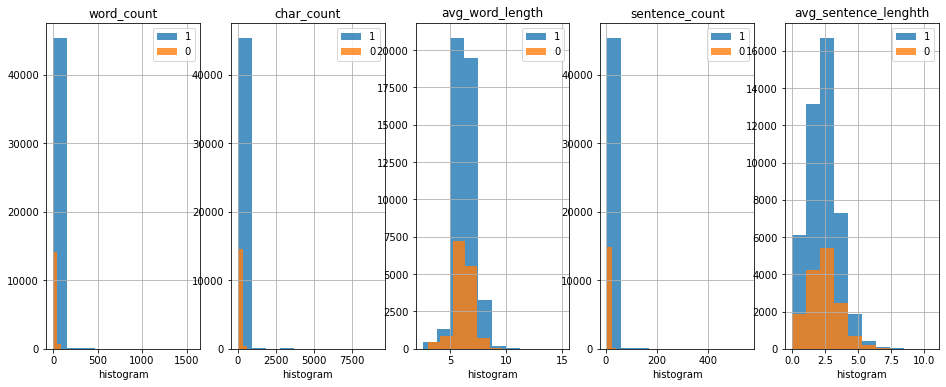

In [72]:
# visualize the distribution of the dataset
x1,x2,x3,x4,x5,y = "word_count","char_count","avg_word_length","sentence_count","avg_sentence_length", "company_paticipants_yes"
fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(16,6))
for i in model_df[y].unique():
    sns.distplot(model_df[model_df[y]==i][x1], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(model_df[model_df[y]==i][x2], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[1])
    sns.distplot(model_df[model_df[y]==i][x3], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[2])
    sns.distplot(model_df[model_df[y]==i][x4], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[3])
    sns.distplot(model_df[model_df[y]==i][x5], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[4])
ax[0].grid(True)
ax[0].legend(model_df[y].unique())
ax[0].set_title("word_count")
ax[1].grid(True)
ax[1].legend(model_df[y].unique())
ax[1].set_title("char_count")
ax[2].grid(True)
ax[2].legend(model_df[y].unique())
ax[2].set_title("avg_word_length")
ax[3].grid(True)
ax[3].legend(model_df[y].unique())
ax[3].set_title("sentence_count")
ax[4].grid(True)
ax[4].legend(model_df[y].unique())
ax[4].set_title("avg_sentence_lenghth")
plt.show()

high frequency words excluding

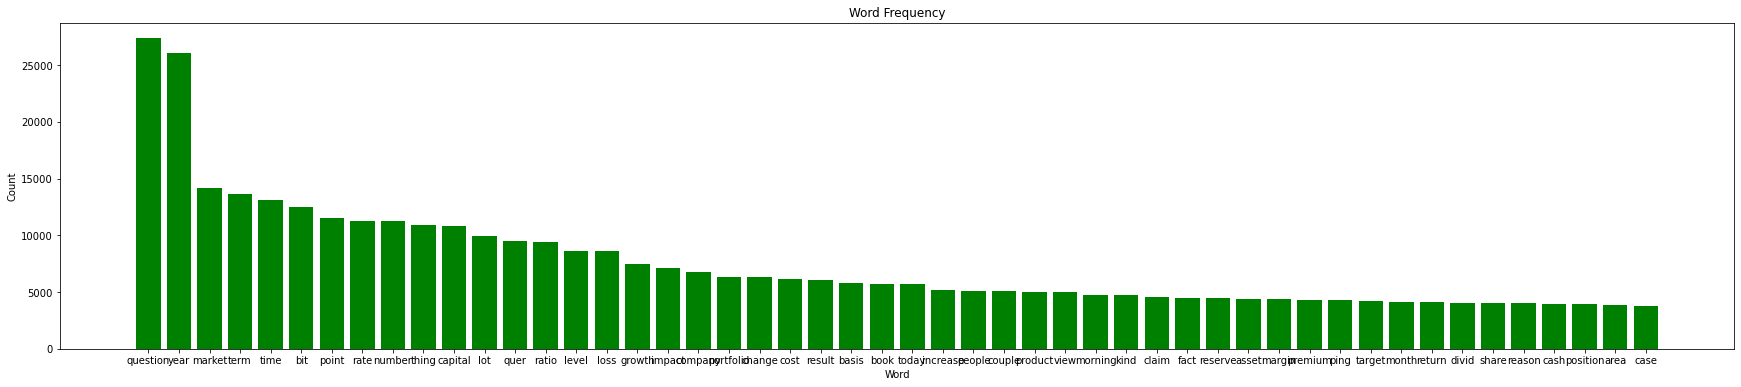

,word,freq
0,question,27369
1,year,26071
2,market,14161
3,term,13637
4,time,13083
...,...,...
8516,reflex,1
8517,willpower,1
8518,clink,1
8519,voucher,1


In [73]:
temp_token = model_df['token'] # .apply(remove_brackets)
docs_tokens = []
for i in temp_token:
    docs_tokens.append(i)
    
# word frequency
# explore word frequencies
word_freq = Counter(x for xs in docs_tokens for x in set(xs)).most_common()
word_fr = pd.DataFrame(word_freq, columns=['word', 'freq']).sort_values(by='freq', ascending=False)

# visualize word frequencies
# figure size
fig = plt.figure(figsize=(30, 6))
plt.bar(word_fr.word[0:50], word_fr.freq[0:50], color='green')
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Word Frequency")
plt.show()
word_fr

In [74]:
# remove 50 most frequent words which is known in this context
word_list = word_fr.head(50)['word'].to_list()
mdy_list, tmp=[],[]
for review in docs_tokens:
    for word in review:
        if word not in word_list:
            tmp.append(word)
    mdy_list.append(tmp)
    tmp=[]

model_df['token'] = mdy_list

# recrate again for getting the docs_tokens
temp_token = model_df['token'] # .apply(remove_brackets)
docs_tokens = []
for i in temp_token:
    docs_tokens.append(i)

In [75]:
# topic modeling
common_terms = [
u"of",u"with",u"without",u"and",u"or",u"the",
u"a",u"not",u"be",u"to",u"this",u"who",u"in",
]

bigram = Phrases(                              
    docs_tokens,
    min_count=50, # 這邊可以調整字連起來
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
trigram = Phrases(                             
    bigram[docs_tokens],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
# anks to these two models, 
# we can process the tokenized documents and join the tokens associated with bi- or tri-grams.
docs_phrased = [trigram[bigram[line]] for line in docs_tokens]
# docs_phrased

In [76]:
len(docs_phrased)

60549

In [77]:
# With Tomotopy, it is necessary to wrap the preprocessed documents in a corpus-like object
# create corpus
corpus = tp.utils.Corpus()                   
for item in docs_phrased:                   
    if item != []:
        corpus.add_doc(words=item)
    else:
        corpus.add_doc(words=" ")
print(len(corpus))

60549


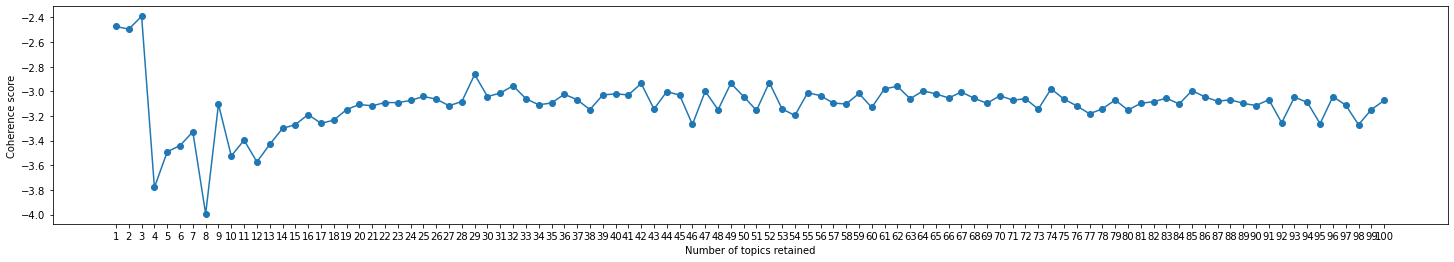

In [78]:
# Explore the fit of surrogate models, i.e. models that retain different numbers of topics.
cvs = {}                                    # step 1 We create an empty dictionary to store the scores of different models.
for topic_number in range(1, 101, 1):        # step 2 We let the number of retained topics vary between models, and for each model we record the associated Coherence Score
    mdl = tp.LDAModel(k=topic_number, corpus=corpus, seed = 1) # our over all words
    for i in range(0, 100, 10): # 100 iterations
        mdl.train(10)
        # print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
    coh = tp.coherence.Coherence(mdl, coherence="u_mass")
    cvs[topic_number] = coh.get_score() # lower is better

# plot the Coherence Score
fig = plt.figure(figsize=(25, 4))
ax = fig.add_subplot(111)
ax.plot(cvs.keys(), cvs.values(), "o-")
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(range(1, 101, 1))
plt.show()

# With 8 topics

In [79]:
# Hence, we train our best fit model.
# 所以，我們訓練我們的最佳模型。
best_mdl = tp.LDAModel(k=8, corpus=corpus, seed = 1)
for i in range(0, 100, 10):
    best_mdl.train(10)
    # print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))
# Using the ‘get_topic_words’ attribute, 
# we retrieve the topic-to-word probabilities, 
# a key outcome of topic modeling. The estimated probabilities are arranged into a Pandas DF.
# 使用“get_topic_words”屬性，我們可以取得主題到詞彙概率的預測，這是主題建模的一個重要結果。
wt = pd.DataFrame()
for k in range(best_mdl.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt = pd.concat([wt, tmp], ignore_index=False)
    del tmp
wt

,word,prob,k,sort
0,fund,0.018,0,0
1,deal,0.016,0,1
2,pension,0.015,0,2
3,cnt,0.013,0,3
4,acquisition,0.012,0,4
...,...,...,...,...
5,guidance,0.017,7,5
6,half,0.016,7,6
7,assumption,0.016,7,7
8,figure,0.013,7,8


In [80]:
import pyLDAvis
# Creating a function to prepare the data for visualisation
def topic_plot_data(best_mdl):
    topic_term_dists = np.stack([best_mdl.get_topic_word_dist(k) for k in range(best_mdl.k)])
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in best_mdl.docs])
    doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
    doc_lengths = np.array([len(doc.words) for doc in best_mdl.docs]) 
    vocab = list(best_mdl.used_vocabs)                                
    term_frequency = best_mdl.used_vocab_freq

    prepared_data = pyLDAvis.prepare(
            topic_term_dists, 
            doc_topic_dists, 
            doc_lengths, 
            vocab, 
            term_frequency,
            start_index=0, 
            sort_topics=False 
        )
    return prepared_data

prepared_data= topic_plot_data(best_mdl)
pyLDAvis.display(prepared_data)

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: t

In [81]:
td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)
td #.head(1).T

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
0,0.015926,0.019701,0.904790,0.006390,0.011261,0.013826,0.011989,0.016117
1,0.038912,0.288675,0.286297,0.015612,0.027513,0.033781,0.029293,0.279918
2,0.038912,0.048134,0.767379,0.015612,0.027513,0.033781,0.029293,0.039377
3,0.026273,0.032499,0.030893,0.010541,0.018576,0.834853,0.019778,0.026587
4,0.031367,0.038801,0.618584,0.012585,0.216078,0.027231,0.023613,0.031742
...,...,...,...,...,...,...,...,...
60544,0.074986,0.092759,0.088175,0.493629,0.053019,0.065098,0.056450,0.075883
60545,0.008025,0.208367,0.009437,0.251269,0.005674,0.503065,0.006041,0.008121
60546,0.179717,0.354105,0.051397,0.002803,0.177671,0.006064,0.005259,0.222984
60547,0.074986,0.092759,0.088175,0.030086,0.053019,0.065098,0.519993,0.075883


In [83]:
# concat the model_df and td
model_df_df_QA8 = pd.concat([model_df, td], axis=1)
# model df drop the token column (tokenized section is too large to save)
model_df_without_token = model_df_df_QA8.drop(['token'], axis=1)
# save to csv
model_df_without_token.to_csv('./main_df_output/topic_modelling_df_QA8.csv', index=False)

# With 4 topics

In [85]:
# Hence, we train our best fit model.
# 所以，我們訓練我們的最佳模型。
best_mdl = tp.LDAModel(k=4, corpus=corpus, seed = 1)
for i in range(0, 100, 10):
    best_mdl.train(10)
    # print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))
# Using the ‘get_topic_words’ attribute, 
# we retrieve the topic-to-word probabilities, 
# a key outcome of topic modeling. The estimated probabilities are arranged into a Pandas DF.
# 使用“get_topic_words”屬性，我們可以取得主題到詞彙概率的預測，這是主題建模的一個重要結果。
wt = pd.DataFrame()
for k in range(best_mdl.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt = pd.concat([wt, tmp], ignore_index=False)
    del tmp
wt

,word,prob,k,sort
0,expense,0.025,0,0
1,trend,0.016,0,1
2,improvement,0.016,0,2
3,half,0.014,0,3
4,motor,0.010,0,4
5,segment,0.009,0,5
6,plan,0.009,0,6
7,volume,0.009,0,7
8,performance,0.009,0,8
9,mix,0.009,0,9


In [86]:
prepared_data= topic_plot_data(best_mdl)
pyLDAvis.display(prepared_data)

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [87]:
td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)
td #.head(1).T

,topic_1,topic_2,topic_3,topic_4
0,0.024695,0.020965,0.022145,0.932195
1,0.312988,0.052549,0.055507,0.578956
2,0.061899,0.052549,0.055507,0.830045
3,0.041206,0.703582,0.204101,0.051111
4,0.049476,0.042003,0.044367,0.864154
...,...,...,...,...
60544,0.124340,0.609933,0.111499,0.154229
60545,0.662901,0.010473,0.111150,0.215476
60546,0.663393,0.009106,0.270685,0.056816
60547,0.124340,0.105558,0.111499,0.658603


In [89]:
# concat the model_df and td
model_df_df_QA4 = pd.concat([model_df, td], axis=1)
# model df drop the token column (tokenized section is too large to save)
model_df_without_token = model_df_df_QA4.drop(['token'], axis=1)
# save to csv
model_df_without_token.to_csv('./main_df_output/topic_modelling_df_QA4.csv', index=False)